In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [69]:
results = pd.read_csv("test_results/pg_duck_hand_tpch_test_results.csv") 
test_name = "postgres_duck_db_hand"

results = results.rename(columns={"Average": "Mean"})

In [70]:
print(len(results))
results.head()

110


,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs
0,SQL,1,Postgres,Query 1,5.95,False,Yes,"[5.438749551773071, 5.925055027008057, 6.24359..."
1,SQL,1,Duck DB,Query 1,0.38,False,Yes,"[0.3842482566833496, 0.3767247200012207, 0.375..."
2,Pandas,1,Pandas Converted (Duck DB),Query 1,1.40,False,Yes,"[1.8379549980163574, 1.312117576599121, 1.3133..."
3,Pandas,1,Pandas Converted (Postgres),Query 1,1.59,False,Yes,"[2.1008336544036865, 1.4961133003234863, 1.483..."
4,Pandas,1,Pandas By-hand,Query 1,1.07,False,Yes,"[1.0855119228363037, 1.073991298675537, 1.0591..."


In [71]:
# Filter for Correct == True and Executed == Yes
# results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

110


In [72]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

results['Median'] = results.apply(lambda row: statistics.median(sorted(row['Runs'])), axis = 1)

def ignore_first_mean(runs):
    return statistics.mean(runs[1:])

results['Mean_first'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]

In [73]:
results = results[results["Data Type"] != "SQL"]
# Rename "Pandas By-hand" to "Pandas Manual"

def rename_specific(q_type):
    if q_type == "Pandas By-hand":
        return "Pandas Manual"
    else:
        return q_type

results['Query Type'] = results.apply(lambda row : rename_specific(row['Query Type']), axis = 1)

In [74]:
# Make ordered results
#order_results = results.sort_values(by=["Mean_first"])
query_order = list(results[results["Query Type"] == "Pandas Converted (Postgres)"].sort_values(by=["Mean_first"])["Query Number"])
#query_order
def query_order_sorter(column):
    """Sort function"""
    correspondence = {query: order for order, query in enumerate(query_order)}
    return column.map(correspondence)

order_results = results.sort_values(by='Query Number', key=query_order_sorter)

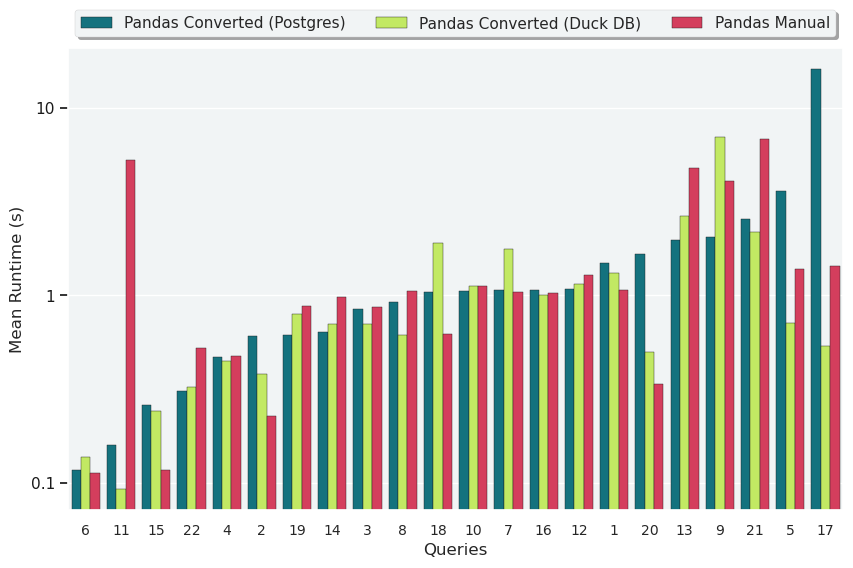

In [75]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

color = ['#028090','#CBFF4D','#ED254E']
order = ["Pandas Converted (Postgres)", "Pandas Converted (Duck DB)", "Pandas Manual"]


ax = sns.barplot(data=order_results, x='Query Number', y='Mean_first', hue='Query Type',
                 palette=color, order=query_order, hue_order=order)

ax.set_yscale("log")
ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

# the non-logarithmic labels 
ticks = [0.1, 1, 10]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=4, fancybox=True, shadow=True)

plt.savefig("analysis_results/" + str(test_name) + "_queries.pdf", bbox_inches="tight")
plt.show()

In [76]:
# Number to show peformance of each, in comparison to each other
group_results = results \
    .groupby(['Query Type'], sort=False) \
    .agg(
        mean_runtime=("Mean_first", "mean"),
    )

group_results = group_results.sort_values(by=["mean_runtime"])
group_results

,mean_runtime
Query Type,
Pandas Converted (Duck DB),1.190961
Pandas Manual,1.609380
Pandas Converted (Postgres),1.799407
